In [ ]:
from getpass import getpass
import os
import sys

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    print("Detected Kaggle environment. Starting setup...")
    username = "vdakov"
    repo_url = f"https://github.com/vdakov/msc-thesis-learning-priors.git"
    !git clone {repo_url} --depth 1
    if os.path.exists("msc-thesis-learning-priors"):
        os.chdir("msc-thesis-learning-priors")
    %ls
    %pip install -r requirements.txt
    if os.path.exists("notebooks"):
        os.chdir("notebooks")

else:
    print("Not running in Kaggle. Skipping Git clone and pip install.")

current_dir = os.getcwd()

if os.path.basename(current_dir) == "notebooks":
    parent_dir = os.path.dirname(current_dir)
else:
    parent_dir = current_dir

src_path = os.path.join(parent_dir, "src")
sys.path.append(src_path)
print(f"Added to sys.path: {src_path}")


Not running in Kaggle. Skipping Git clone and pip install.
Added to sys.path: /home/vdakov/Desktop/thesis/msc-thesis-vasko/src


In [2]:
import models.encoders as encoders
from training_util import get_uniform_single_eval_pos_sampler, get_weighted_single_eval_pos_sampler, get_cosine_schedule_with_warmup
import train
from criterion.bar_distribution import BarDistribution, get_bucket_limits
from models import positional_encodings
from prior_generation import gp_prior, gp_lengthscale_prior
import torch
import torch.distributions as dist
from samplers.distribution_samplers import DistributionSampler
from samplers.distributions import ScaledBernoulli
import load_config

In [4]:
config = {
    'definitions': {
        'num_features': 1,
        'num_outputs': 100,
        'sequence_length': 10,
        'max_eval_pos': 9
    },
    'training_configuration': {
        'epochs': 1,
        'batch_size': 16,
        'warmup_epochs': 25,
        'steps_per_epoch': 10,
        'validation_context_pos': 9,
        'sequence_length': 10,
        'lr': 0.0001,
        'scheduler': 'cosine_scheduler',
        'aggregate_k_gradients': 1,
        'context_delimiter_sampling': 'uniform',
        'context_delimiter_max_eval_pos': 9,
        "num_test_parameters": 1
    },
    'transformer_configuration': {
        'emsize': 512,
        'fuse_x_y': False,
        'nlayers': 6,
        'num_features': 1,
        'nhead': 4,
        'nhid': 1024,
        'num_outputs': 100,
        'dropout': 0.2,
        'input_normalization': True,
        'encoder_type': 'linear',
        'pos_encoder_type': 'none',
        'y_encoder_type': 'linear'
    },
    'prior_configuration': {
        'prior_learning': False,
        'type': 'gaussian_process_prior',
        'hyperparams': {
            'kernel': 'rbf',
            'length_scale': 0.5,
            'output_scale': 1,
            'noise_std': 0.001,
            'num_features': 1,
            'num_outputs': 100
        }
    },
    'criterion_configuration': {
        'loss': 'bar_distribution',
        'min_y': -5,
        'max_y': 5,
        'num_buckets': 100
    }
}


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# transformer_configuration, training_configuration, criterion, generators, prior, prior_hyperparameters, context_delimiter_generator = load_config.load_config_from_yaml('../src/configs/vanilla_pfn.yaml')
transformer_configuration, training_configuration, criterion, generators, prior, prior_hyperparameters, context_delimiter_generator = load_config.parse_config_dict(config)

KeyError: 'use_cache'

In [ ]:
model, losses, positional_losses, val_losses = train.train(
    prior_dataloader=prior,
    criterion=criterion, # Passing the wrapper
    transformer_configuration=transformer_configuration,
    generators = generators,
    training_configuration=training_configuration,
    prior_hyperparameters=prior_hyperparameters,
    context_delimiter_generator = context_delimiter_generator,
    save_folder="../results",
    load_path="../results/test-model/checkpoint.pt",
    experiment_name="test-model",
    device=device
)

In [ ]:
import visualization.training_plots as training_plots 
training_plots.plot_training_validation_loss(losses, val_losses, title="Training and Validation Loss")

In [ ]:
num_points_in_dataset = 15
num_training_points = num_points_in_dataset - 5
num_datasets = 9

train_X, train_Y, y_target, _ = prior.get_datasets_from_prior(num_datasets, num_points_in_dataset, 1, **prior_hyperparameters)
train_X = train_X.to(device)
train_Y = train_Y.to(device)
y_target = y_target.to(device)

In [ ]:
from visualization.prediction_visualization import show_vanilla_pfn_predictions

show_vanilla_pfn_predictions(model, train_X, train_Y, num_datasets, num_training_points, device)

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# transformer_configuration, training_configuration, criterion, generators, prior, prior_hyperparameters, context_delimiter_generator = load_config.load_config_from_yaml('../src/configs/prior_learning_pfn.yaml')
config = {
    'definitions': {
        'num_features': 1,
        'num_outputs': 250,
        'sequence_length': 25,
        'max_eval_pos': 25,
    },
    'training_configuration': {
        'epochs': 1,
        'batch_size': 16,
        'warmup_epochs': 25,
        'steps_per_epoch': 10,
        'validation_context_pos': 25,
        'sequence_length': 25,
        'lr': 0.0001,
        'scheduler': 'cosine_scheduler',
        'aggregate_k_gradients': 1,
        'context_delimiter_sampling': 'constant_last',
        'context_delimiter_max_eval_pos': 25,
        "num_test_parameters": 1
    },
    'transformer_configuration': {
        'emsize': 512,
        'fuse_x_y': False,
        'nlayers': 6,
        'num_features': 1,
        'nhead': 4,
        'nhid': 1024,
        'num_outputs': 100,
        'dropout': 0.2,
        'input_normalization': True,
        'encoder_type': 'linear',
        'pos_encoder_type': 'none',
        'y_encoder_type': 'linear'
    },
    'prior_configuration': {
        'prior_learning': True,
        'type': 'gaussian_process_lengtscale_prior',
        'hyperparams': {
            'kernel': 'rbf',
            "samplers": {
              "length_scale": {
                "distribution": "scaled_bernoulli", #, 'bernoulli'
                "low": 0.4,
                "high": 0.6,
                "p": 0.5,
              }
    
            },
            'output_scale': 1,
            'noise_std': 0.001,
            'num_features': 1,
            'num_outputs': 250
        },
        "use_cache": False,
        "cache_path": "../cached_datasets/2mil-gp-hyperpriors.pt"
    },
    'criterion_configuration': {
        'loss': 'bar_distribution',
        'min_y': -5,
        'max_y': 5,
        'num_buckets': 250
    }
}


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# transformer_configuration, training_configuration, criterion, generators, prior, prior_hyperparameters, context_delimiter_generator = load_config.load_config_from_yaml('../src/configs/prior_learning_pfn.yaml')
transformer_configuration, training_configuration, criterion, generators, prior, prior_hyperparameters, context_delimiter_generator = load_config.parse_config_dict(config)

torch.Size([251])


/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'samplers.distributions.ScaledBernoulli'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [7]:
prior.cache_datasets(1280000, 256, 15, 1, "cpu", **prior_hyperparameters)
prior.save_cache("../cached_datasets/1p28М-gp-hyperprior.pt")
prior.sample_cache(4, "cpu")

Generating cache of 1280000 datasets...


Caching Progress:   0%|          | 0/5000 [00:00<?, ?it/s]/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Caching Progress:   0%|          | 1/5000 [00:00<54:14,  1.54it/s]/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
Caching Progress:  44%|████▍     | 2191/5000 [00:14<00:18, 149.61it/s]


KeyboardInterrupt: 

In [4]:
model, losses, positional_losses, val_losses = train.train(
    prior_dataloader=prior,
    criterion=criterion, # Passing the wrapper
    transformer_configuration=transformer_configuration,
    generators = generators,
    training_configuration=training_configuration,
    prior_hyperparameters=prior_hyperparameters,
    # load_path="../results/test-model-2/checkpoint.pt",
    context_delimiter_generator = context_delimiter_generator,
    save_folder="../results",
    experiment_name="test-model-2",
    device=device
)

/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Using cpu device
Total Number of Datasets: 160


  0%|          | 0/1 [00:00<?, ?it/s]/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
loss  2.51 | pos loss   nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 2.51, lr 0.0 val score 2.584843158721924: 100%|██████████| 1/1 [00:15<00:00, 15.61s/it]
/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Plots and model saved to ../results/experiment_2026-01-29_00-41-01


/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'samplers.distributions.ScaledBernoulli'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


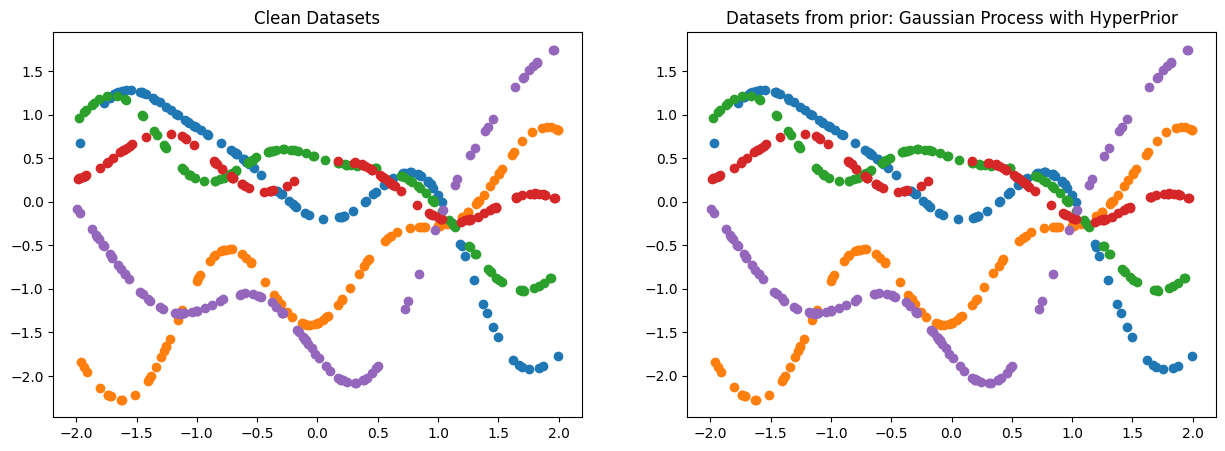

In [6]:
num_points_in_dataset = 100
hyperparameters = { 'kernel': "rbf", 'length_scale': 0.4, "samplers": {"length_scale": DistributionSampler(ScaledBernoulli(low=0.4, high=0.6, prob=1.0))}}
prior.visualize_datasets(number_of_datasets=5, num_points_per_dataset=num_points_in_dataset, num_features_per_dataset=1, device='cpu', **hyperparameters)
train_X, train_Y, y_target, lengthscale = prior.get_datasets_from_prior(1, num_points_in_dataset, 1, **hyperparameters)

train_X = train_X.to(device)
train_Y = train_Y.to(device)
y_target = y_target.to(device)
num_training_points = num_points_in_dataset

In [7]:
from model_evaluation.evaluate_with_context import evaluate_parameter_distributions_on_model

outputs = evaluate_parameter_distributions_on_model(train_X, train_Y, model, device, num_training_points)
# outputs

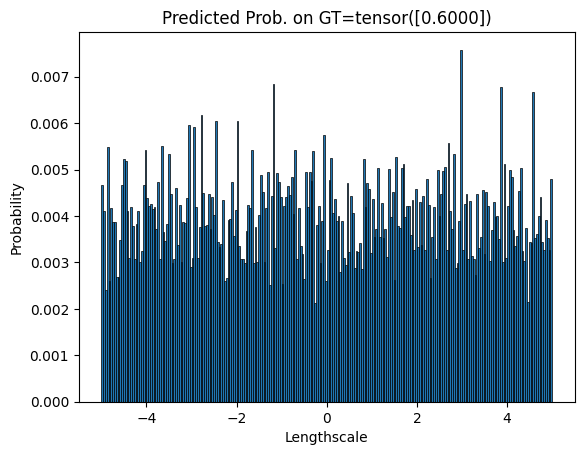

In [12]:
from visualization.prediction_visualization import show_prior_pfn_predictions

show_prior_pfn_predictions(model, outputs, 0.0001, ["Lengthscale"], lengthscale)

In [13]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, lengthscale, variance=1.0):
    dists = cdist(X1, X2, metric='sqeuclidean')
    return variance * np.exp(-0.5 * dists / (lengthscale ** 2))


true_lengthscale = 0.4
X = np.random.uniform(0, 1, size=(10, 1))
K_true = rbf_kernel(X, X, lengthscale=true_lengthscale)
y = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_true).reshape(-1, 1)


def nll_fn_robust(theta, X, y):
    ls = np.exp(theta[0])      # Lengthscale
    sigma_f = np.exp(theta[1]) # Signal Variance (Output scale)
    sigma_n = np.exp(theta[2]) # Noise Variance
    
    n = len(y)
    # Ensure X is 2D and y is 1D
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    y = y.ravel()

    K = sigma_f**2 * np.exp(-0.5 * cdist(X, X, 'sqeuclidean') / ls**2) + (sigma_n**2 + 1e-6) * np.eye(n)
    
    try:
        L = np.linalg.cholesky(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        data_fit = 0.5 * y.T @ alpha
        complexity = np.sum(np.log(np.diag(L)))
        constant = 0.5 * n * np.log(2 * np.pi)
        return (data_fit + complexity + constant).item()
    except np.linalg.LinAlgError:
        return 1e10

# Optimize Lengthscale, Signal Variance, and Noise Variance
initial_params = [np.log(0.4), np.log(1.0), np.log(1e-3)]
res = minimize(nll_fn_robust, x0=initial_params, args=(X, y), method='L-BFGS-B')

recovered_ls = np.exp(res.x[0])

print(f"True Lengthscale: {true_lengthscale}")
print(f"Recovered Lengthscale: {recovered_ls:.4f}")

True Lengthscale: 0.4
Recovered Lengthscale: 0.3059


/home/vdakov/.conda/envs/thesis/lib/python3.14/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


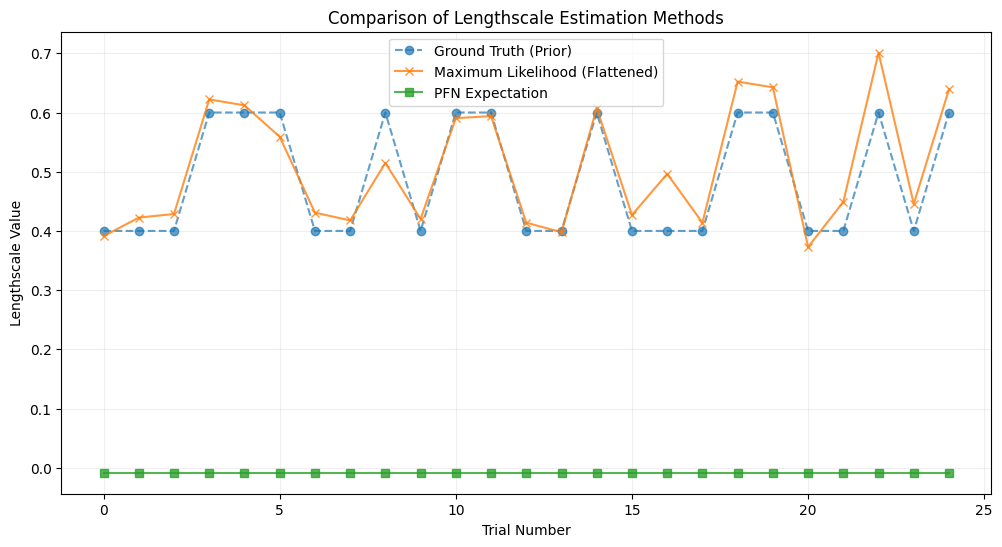

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

borders_all = model.criterion.borders.detach().cpu().numpy()
# 1. Pre-calculate bin midpoints from borders
# If borders_all is shape (251,), midpoints will be (250,)
bin_midpoints = (borders_all[:-1] + borders_all[1:]) / 2
# print(bin_midpoints)
# Ensure midpoints are a torch tensor on the correct device
bin_midpoints_tensor = torch.tensor(bin_midpoints, device=device, dtype=torch.float32)

# Lists to store values for the plot
gt_list = []
ml_list = []
pfn_list = []

import copy


for i in range(25):
    num_points_in_dataset = 15
    num_training_points = num_points_in_dataset
    hyperparameters = copy.deepcopy(prior_hyperparameters)
    hyperparameters["use_cache"] = False

    # Generate data
    train_X, train_Y, y_target, lengthscale = prior.get_datasets_from_prior(
        1, num_points_in_dataset, 1, **hyperparameters
    )
    train_X, train_Y = train_X.to(device), train_Y.to(device)

    outputs = evaluate_parameter_distributions_on_model(
        train_X, train_Y, model, device, num_training_points
    )
    probs = outputs.squeeze()
    # print(probs)
    # print(bin_midpoints_tensor)
    # print("--------------")
    lengthscale_expectation = torch.sum(probs * bin_midpoints_tensor).item()
    # print("Expectation", lengthscale_expectation)
    # print('-------------')

    # 3. Maximum Likelihood Estimation
    X_np = train_X[:, :, 0].cpu().numpy()
    y_np = train_Y[:, 0].detach().cpu().numpy()
    initial_params = [np.log(1), np.log(1.0), np.log(0.001)]
    res = minimize(
        nll_fn_robust, x0=initial_params, args=(X_np, y_np), method="L-BFGS-B"
    )
    ml_ls = np.exp(res.x[0])

    # if ml_ls < 0.5:
    #     ml_ls = 0.4
    # elif ml_ls >= 0.5:
    #     ml_ls = 0.6

    # print(lengthscale_expectation)
    # if lengthscale_expectation < 0.5:
    #     lengthscale_expectation = 0.3
    # elif lengthscale_expectation >= 0.5:
    #     lengthscale_expectation = 0.7
    # Store results
    gt_list.append(lengthscale.item() if torch.is_tensor(lengthscale) else lengthscale)
    ml_list.append(ml_ls)
    pfn_list.append(lengthscale_expectation)

# 4. Create the Line Plot
plt.figure(figsize=(12, 6))
plt.plot(gt_list, label="Ground Truth (Prior)", marker="o", linestyle="--", alpha=0.7)
plt.plot(ml_list, label="Maximum Likelihood (Flattened)", marker="x", alpha=0.8)
plt.plot(pfn_list, label="PFN Expectation", marker="s", alpha=0.8)

plt.xlabel("Trial Number")
plt.ylabel("Lengthscale Value")
plt.title("Comparison of Lengthscale Estimation Methods")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.savefig("lengthscale_comparison.png")
plt.show()
